In [19]:
import sys
import os
import struct
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/code/')
root = os.path.dirname(os.path.dirname(os.getcwd()))
from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_plotting_defaults()
from utils import roi_utils, nsd_utils, default_paths, stats_utils

In [20]:
# Load results of the fitting procedure

subject = 1
volume_space=True
semantic_discrim_type = 'animacy'
fitting_type = 'full_midlevel_plus_semantic_%s_plus_alexnet_best_layer_pca'%(semantic_discrim_type)

root = os.path.dirname(os.path.dirname(os.getcwd()))
out, fig_save_folder = load_fits.load_fit_results(subject, volume_space, fitting_type, n_from_end=0, root=root, verbose=True);

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)

loading from /user_data/mmhender/imStat/model_fits/S01/full_midlevel_plus_semantic_animacy_plus_alexnet_best_layer_pca/Dec-14-2021_0325_30/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'zscore_in_groups', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_best_layer_fn', 'corr_each_feature', 'discrim_each_axis', 'semantic_discrim_type', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'lda_discrim_type', 'max_pc_to_retain_pyr_ll', 'max_pc_to_retain_pyr_hl', 'use_pca_pyr_feats_ll', 'use_pca_pyr_feats_hl', 'pyramid_feature_info', 'group_all_hl_feats', 'feature_table_simple', 'filter_pars_simple', 'or

In [21]:
# roi_def = roi_utils.get_combined_rois(subject,include_all=False,include_body=False,volume_space=True,verbose=False) 
roi_def = roi_utils.get_combined_rois(subject,include_all=True,include_body=True,volume_space=True,verbose=False) 

skip_inds = [10,11,15,23]
retlabs, facelabs, placelabs, bodylabs, \
        ret_names, face_names, place_names, body_names = roi_def


In [23]:
for ll in range(5):
    inds = np.where(out['best_layer_each_voxel']==ll)[0];
    print(np.where(out['best_params'][1][inds[0],:,0]!=0))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 737, 738, 739, 740, 741, 742,
       743, 744, 837, 838, 839, 840, 841, 842, 843]),)
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
       

In [24]:
from utils import stats_utils
from plotting import plot_prf_params

port=63333

best_ecc_deg, best_angle_deg, best_size_deg = plot_prf_params.get_prf_pars_deg(out, screen_eccen_deg=8.4)

names = ['pRF eccentricity', 'pRF angle', \
         'pRF size']
maps = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins = [0,0,0]
maxes = [7, 360, 8.4]

val_r2 = out['val_r2']

names += ['best AlexNet layer (individual R2)', 'R2 best single layer alexnet fit']
maps += [(best_layer+1).astype(np.float32),np.sqrt(val_r2[:,1])]
cmaps += ['plasma_r', 'PuBu']
mins += [0, 0]
maxes += [5, 0.8]

# variance partition
pp0 = 0
pp1 = 1
pp2 = 2
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])
var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)
# var_expl[bad_voxels,:] = np.nan

max_ind = (np.argmax(var_expl[:,1:3], axis=1)+2).astype(np.float32)
max_ind[max_ind==2] = 1.5

# max_ind[bad_voxels] = np.nan

maps += [copy.deepcopy(np.sqrt(var_expl[:,ii])) for ii in range(4)] + [copy.deepcopy(max_ind)]

names  += ['Concat model','Unique var: alexnet', 'Unique var: %s'%semantic_discrim_type, 'Shared variance', \
          'Unique var greater for alexnet or %s'%semantic_discrim_type]
cmaps += ['PuBu', 'PuBu', 'PuBu', 'PuBu', 'plasma_r']
mins += [0, 0, 0, 0, 0]
maxes += [0.8, 0.8, 0.8, 0.8, 3]


maps += [copy.deepcopy(np.sqrt(val_r2[:,ii])) for ii in list([1,2])]

names  += ['R2: alexnet', 'R2: %s'%semantic_discrim_type]
cmaps += ['PuBu', 'PuBu']
mins += [0, 0]
maxes += [0.8, 0.8]

vox2plot = val_r2[:,0]>=0

plot_utils.plot_maps_pycortex(maps, names, subject, out, roi_def=roi_def, vox2plot=vox2plot, \
                              fitting_type='alexnet + %s'%semantic_discrim_type, \
                              port=port, cmaps=cmaps, mins=mins, maxes=maxes)


NameError: name 'best_layer' is not defined

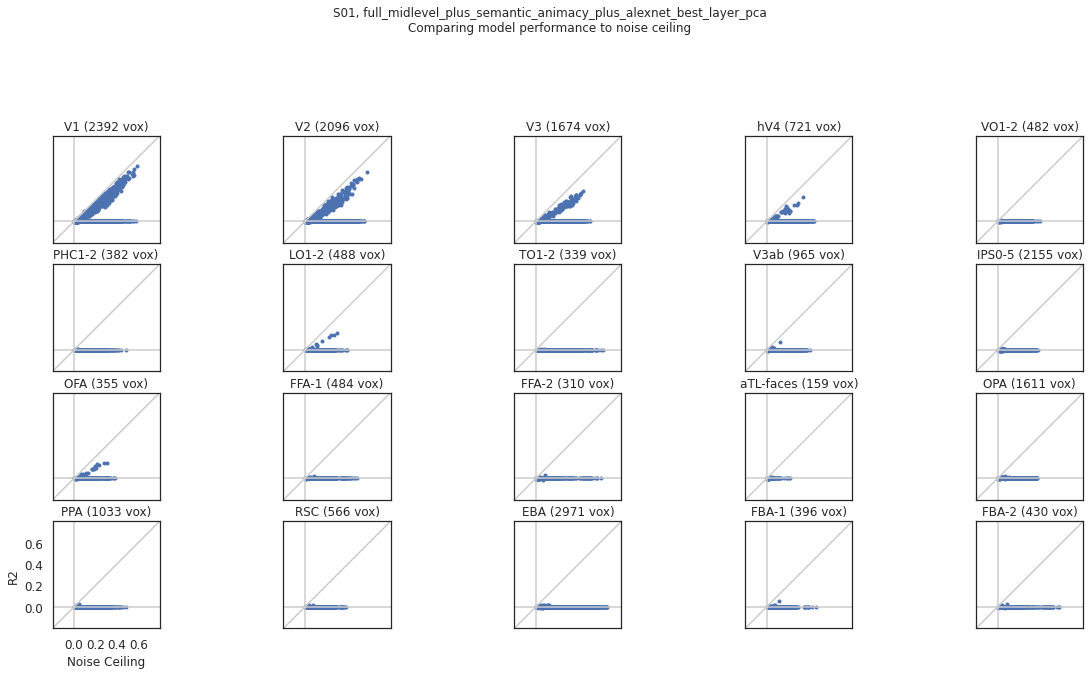

In [25]:
plot_utils.set_all_font_sizes(fs = 12)
summary_plots.plot_r2_vs_nc(subject, fitting_type, out, roi_def=roi_def, skip_inds=skip_inds, \
                            fig_save_folder=fig_save_folder,axlims = [-0.2, 0.8])

In [27]:
np.sum(out['val_r2'][:,0]!=0.0)

3869

In [32]:
neach = [np.sum(out['best_layer_each_voxel']==ii) for ii in range(5)]
print(neach)
print(np.sum(np.array(neach)))

[1066, 2803, 4882, 5044, 5943]
19738


In [34]:
good_voxels = out['val_r2'][:,0]!=0;
neach = [np.sum(out['best_layer_each_voxel'][good_voxels]==ii) for ii in range(5)]
print(neach)

[1066, 2803, 0, 0, 0]


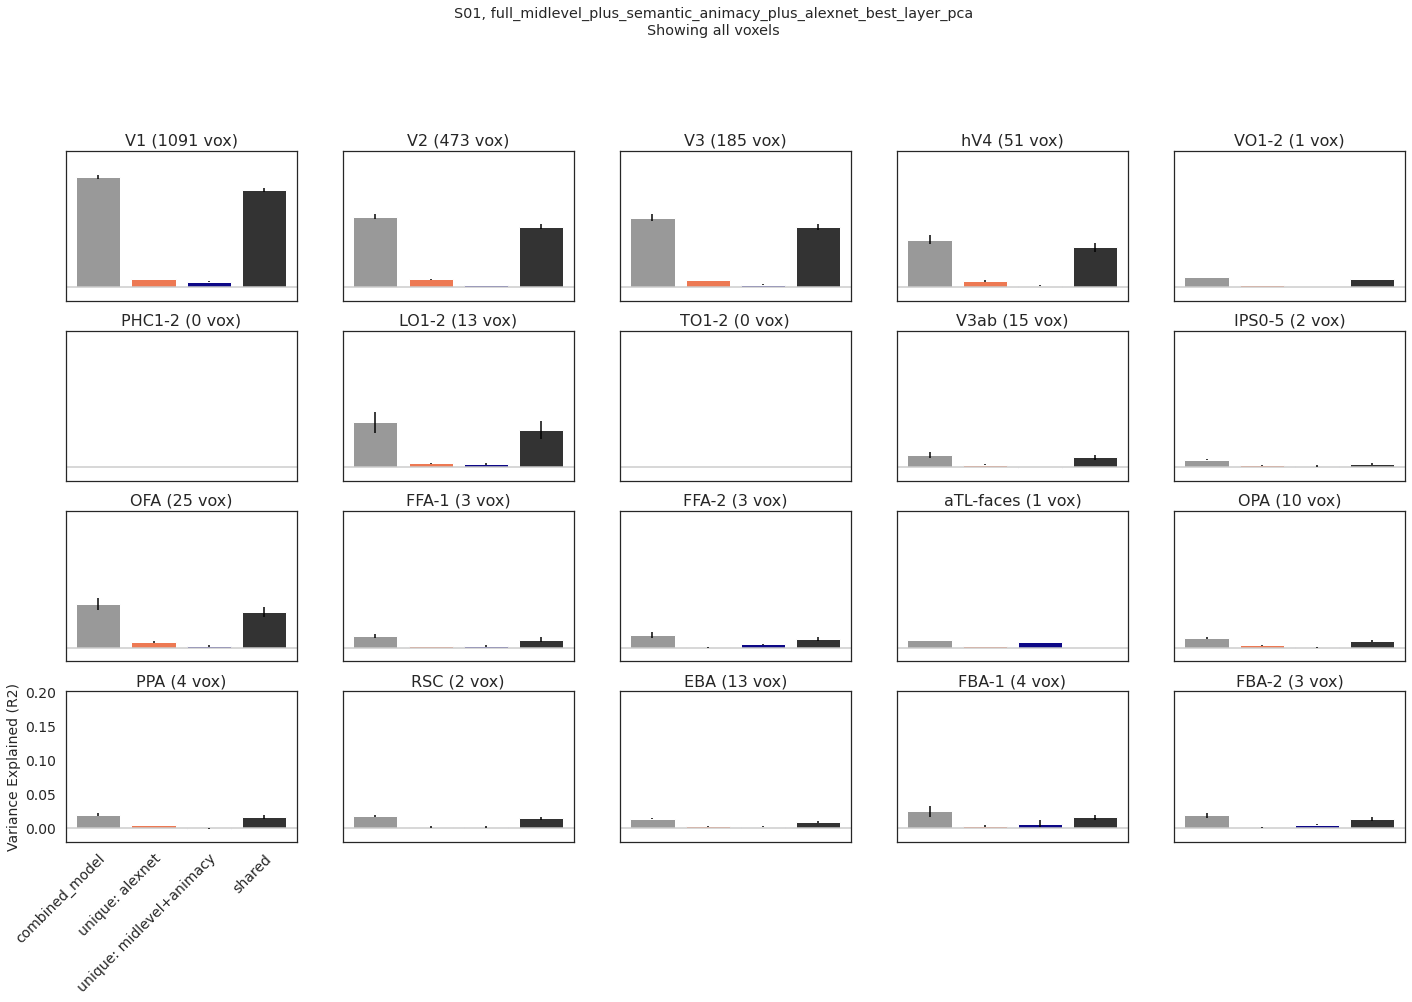

In [17]:
pp0 = 0
pp1 = 13
pp2 = 14

# for each voxel, choosing which fits to use based on its best layer
val_r2 = out['val_r2']

name1 = 'alexnet'
name2 = 'midlevel+%s'%semantic_discrim_type

ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

bp = plot_utils.bar_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.02, 0.20])
plot_utils.create_roi_subplots(var_expl, inds2use, bp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)


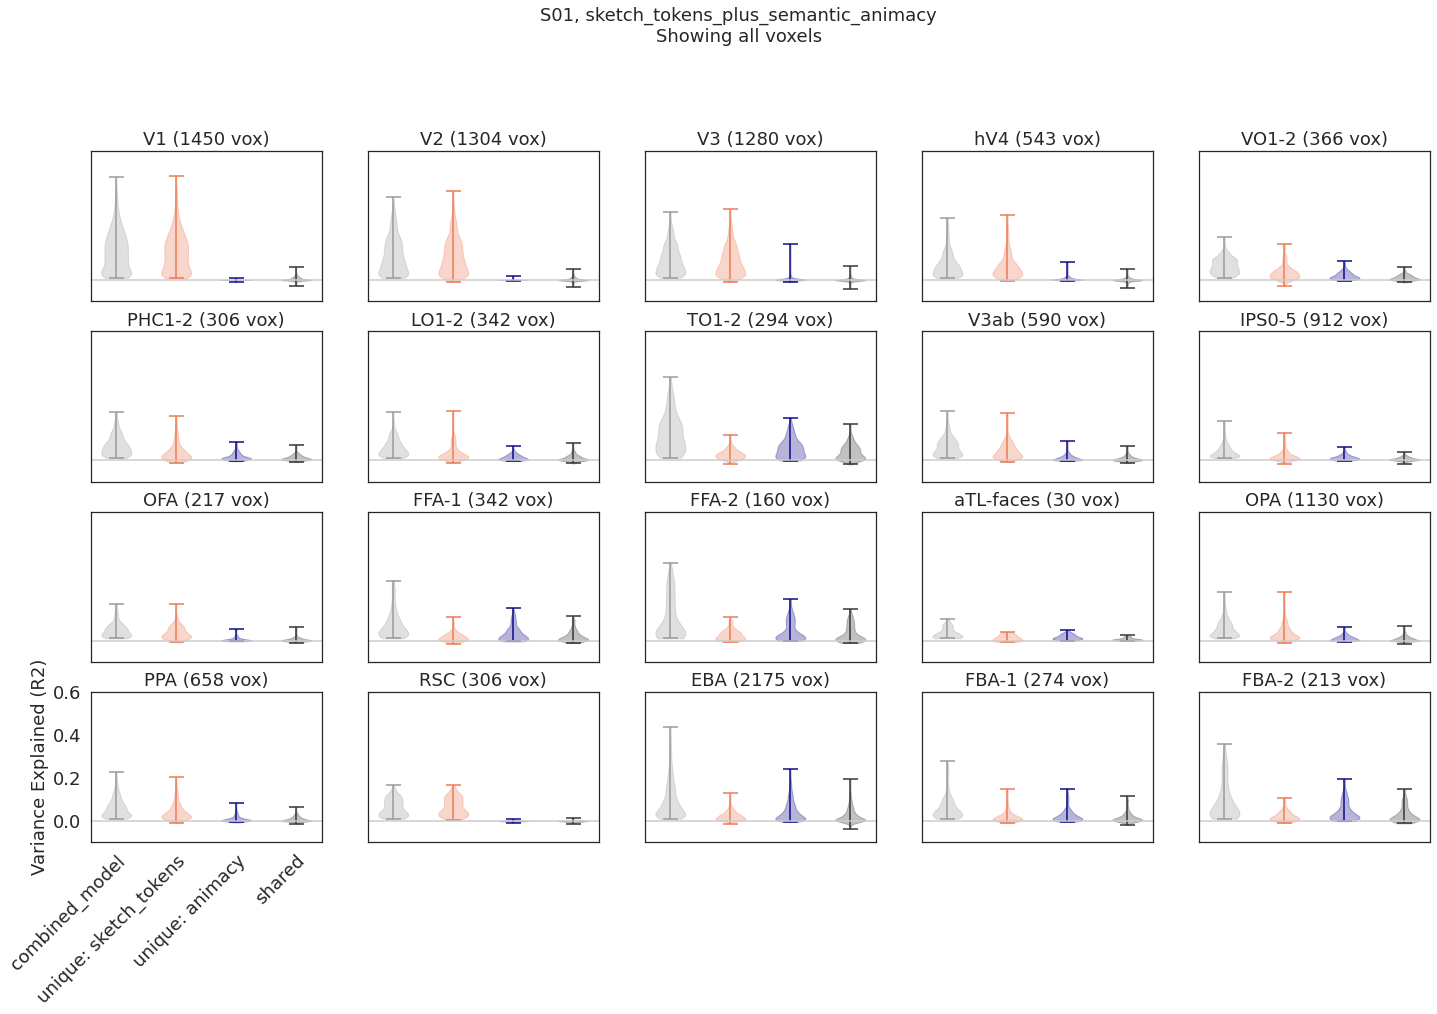

In [9]:
pp0 = 0
pp1 = 1
pp2 = 2

name1 = out['partial_version_names'][pp1][5:]
name2 = out['partial_version_names'][pp2][5:]
# val_r2 = stats_utils.get_r2(out)
val_r2 = out['val_r2']
ve_names = ['combined_model', 'unique: ' + name1, 'unique: ' + name2, 'shared']
shared_ab, unique_a, unique_b = stats_utils.get_shared_unique_var(val_r2[:,pp0], val_r2[:,pp1], val_r2[:,pp2])

var_expl = np.concatenate((val_r2[:,pp0:pp0+1], unique_a[:,np.newaxis], unique_b[:,np.newaxis],shared_ab[:,np.newaxis]),axis=1)

colors = cm.plasma(np.linspace(0,1,4))
colors = np.flipud(colors)
colors = np.concatenate((np.array([[0.6, 0.6, 0.6, 1]]), colors[[1,3],:], np.array([[0.2, 0.2, 0.2, 1]])), axis=0)

inds2use = val_r2[:,0]>0.01

vp = plot_utils.violin_plot(colors=colors, column_labels=ve_names, ylabel='Variance Explained (R2)', \
                                                        horizontal_line_pos=0, ylims=[-0.10, 0.60])
plot_utils.create_roi_subplots(var_expl, inds2use, vp, subject, out, roi_def=roi_def, skip_inds=skip_inds,\
                    suptitle='S%02d, %s\nShowing all voxels'%(subject, fitting_type))

plt.gcf().subplots_adjust(bottom=0.4)

if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.pdf'))
    plt.savefig(os.path.join(fig_save_folder,'Varpart_texture_ST_violin_eachroi.png'))